In [15]:
import os
from preprocessing import *
import torch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
import pylab as pl
from IPython import display

from tqdm import tqdm

In [16]:
BASE_PATH = "c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation"+ "\\ICPR"
TRAINING_PATH= BASE_PATH + "\\train\\"

TEST_PATH= BASE_PATH + "/test/"

In [17]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "pathsT2":[],
    "mask" :[]
}
createDictionary(TRAINING_PATH, TRAINING_DICT)
print(TRAINING_DICT.get("pathsFLAIR").__getitem__(0))
print(TRAINING_DICT.get("pathsT1").__getitem__(0))
print(TRAINING_DICT.get("pathsT2").__getitem__(0))
print(TRAINING_DICT.get("mask").__getitem__(0))
print(len(TRAINING_DICT.get("pathsFLAIR")))

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_T1.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_T2.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_MASK.nii.gz
93


In [18]:
# TEST_DICT={
#     "pathsFLAIR":[],
#     "pathsT1":[],
#     "pathsT2":[],
#     "mask" :[],
# }
# createDictionary(TEST_PATH, TEST_DICT)
# print(TEST_DICT.get("pathsFLAIR").__getitem__(0))
# print(TEST_DICT.get("pathsT1").__getitem__(0))
# print(TEST_DICT.get("pathsT2").__getitem__(0))
# print(TEST_DICT.get("mask").__getitem__(0))

# DATASET

In [19]:
transform=transforms.Compose([
    transforms.ToTensor(),
])


In [20]:
train,val = getIDsICPR(TRAINING_DICT)

In [21]:
print(len(train.get('pathsFLAIR')))
print(len(val.get('pathsFLAIR')))

74
19


(182, 218, 182)


(-0.5, 181.5, 181.5, -0.5)

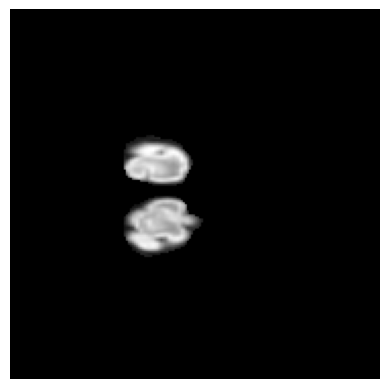

In [22]:
flair = nib.load(os.path.join(TRAINING_PATH, "P47", "T1", "P47_T1_FLAIR.nii.gz"))
flair_im= flair.get_fdata()
#flair_im = flair_im[39:-39,41:-41,39:-39] 
print(flair_im.shape)
plt.imshow(flair_im[:,25, :], cmap='gray')
plt.axis('off')

(182, 218, 182)


(-0.5, 181.5, 181.5, -0.5)

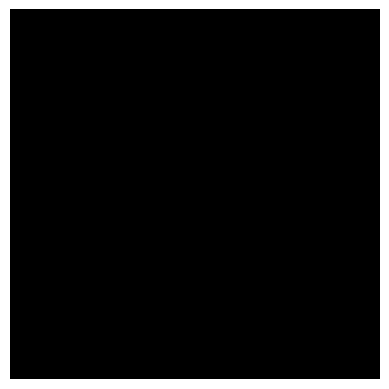

In [23]:
img = nib.load(os.path.join(TRAINING_PATH, "P48", "T1", "P48_T1_MASK.nii.gz"))
image_data = img.get_fdata() 
print(image_data.shape)
plt.imshow(image_data[:, 25 ,:], cmap='gray')
plt.axis('off')

# 3D-NET

In [24]:
train_data = ICPR(train.get("pathsFLAIR"),train.get("pathsT1"),train.get("pathsT2"), train.get("mask"),transform, transform)
val_data = ICPR(val.get("pathsFLAIR"),val.get("pathsT1"),val.get("pathsT2"), val.get("mask"),transform, transform)

In [25]:
train_dl = DataLoader(train_data, batch_size=1,num_workers=3,shuffle=True)
val_dl = DataLoader(val_data, batch_size=1,num_workers=3, shuffle=False)

In [26]:
from UNet3D import UNet3D 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=1, num_classes=1)
model = model.to(device)
criterion = DiceLoss()
criterion.smooth = 1e-5
optimizer = Adam(model.parameters(), lr=0.0005)

In [27]:
def traintestpipeline(epochs: int, optim: Adam, criterion: DiceLoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        

            input_img= input_img.to(device).float()
            target = target.to(device).float()
            input_img=input_img.unsqueeze(0)
            
            output = model(input_img)
            loss = criterion(output.squeeze(), target.squeeze())
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()    
                                                        
        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in val_dl: 
                input_img = input_img.to(device).float()
                target = target.to(device)
                input_img=input_img.unsqueeze(0)

                output = model(input_img)                                   
                loss = criterion(output.squeeze(), target.squeeze())   
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(val_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

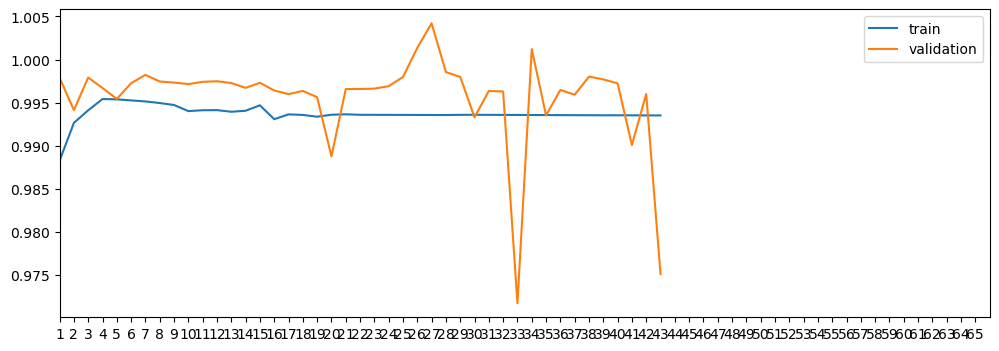

Epoch:43 Training Loss:0.993516066589871 Validation Loss:0.9751089200297013:  66%|██████▌   | 43/65 [2:27:30<1:16:28, 208.56s/it] 

In [28]:
traintestpipeline(65,optimizer,criterion,1000,"PRUEBAICPR.pt")

In [ ]:
model = UNet3D(in_channels=1, num_classes=1)
model = model.to(device)
criterion = DiceLoss()
criterion.smooth = 1e-5
optimizer = Adam(model.parameters(), lr=1e-3)
traintestpipeline(65,optimizer,criterion,1000,"PRUEBAICPR2.pt")

In [ ]:
model = UNet3D(in_channels=1, num_classes=1)
model = model.to(device)
criterion = DiceLoss()
criterion.smooth = 1e-5
optimizer = Adam(model.parameters(), lr=1e-2)
traintestpipeline(65,optimizer,criterion,1000,"PRUEBAICPR3.pt")

In [ ]:
model = UNet3D(in_channels=1, num_classes=1)
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("PRUEBAICPR.pt"))
mmodel.eval()

UNet3D(
  (a_block1): Conv3DBlock(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a_block2): Conv3DBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
def generador(loader):
    for data, target in loader:
        data, target = data.to(device).float(), target.float().to(device)
        yield data, target 
def showsegmentation(test_dl, mmodel):               
    with torch.no_grad():
        gen = generador(test_dl)

        data, true_labels = next(gen)
        data = data.unsqueeze(0)
        mmodel.eval()

        output = mmodel(data)

        #binary_mask_resized = output.squeeze().cpu().numpy()
        binary_mask_resized = true_labels.squeeze().cpu().numpy()
        print(binary_mask_resized.shape)
        verts,faces,_,_ = marching_cubes(binary_mask_resized, step_size=1)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        mesh = Poly3DCollection(verts[faces], alpha=0.9)
        face_color = [0.45,0.75, 0.45]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)
        ax.set_xlim(0, binary_mask_resized.shape[0])
        ax.set_ylim(0, binary_mask_resized.shape[1])
        ax.set_zlim(0, binary_mask_resized.shape[2])
        #show 3 gifs 
    plt.tight_layout()
    plt.show()
        
        

(24, 24, 24)


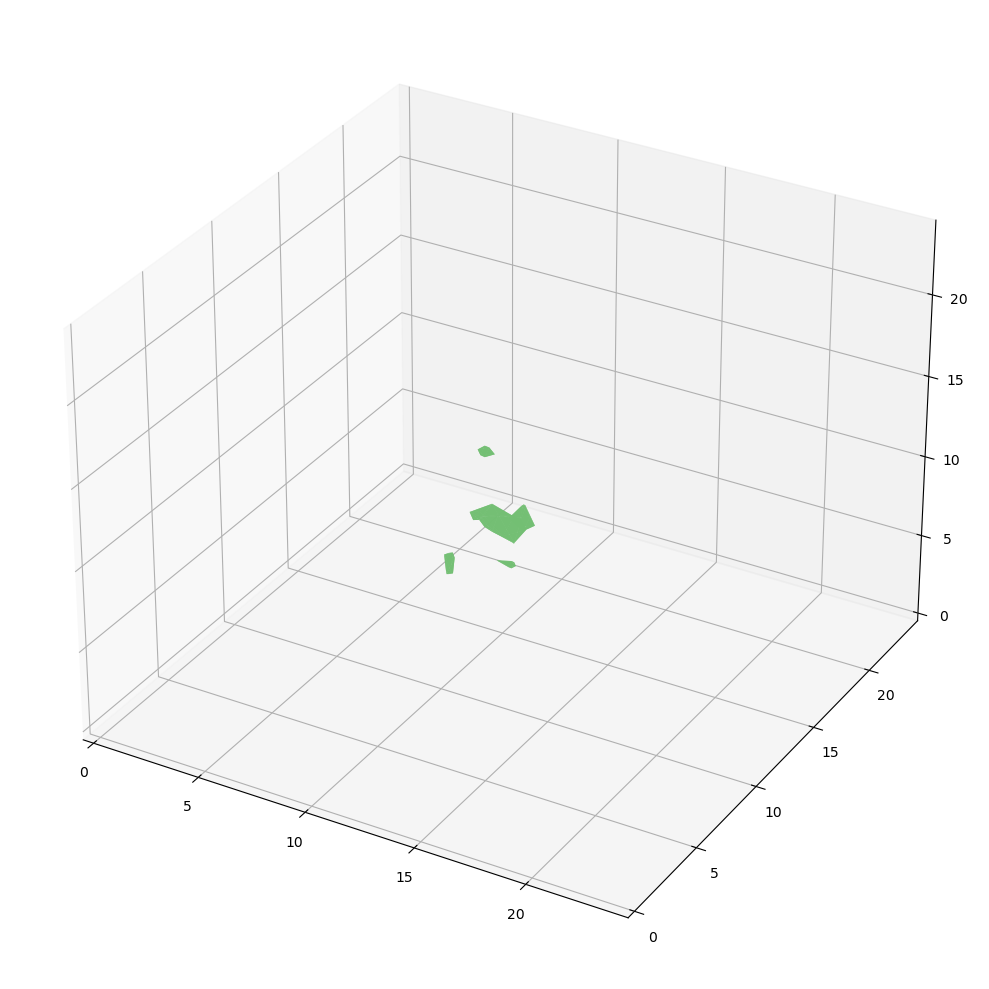

In [ ]:
showsegmentation(val_dl,mmodel)

https://www.youtube.com/watch?v=WBJH_B-CYLY&ab_channel=FatemehBehrad

KeyboardInterrupt: 

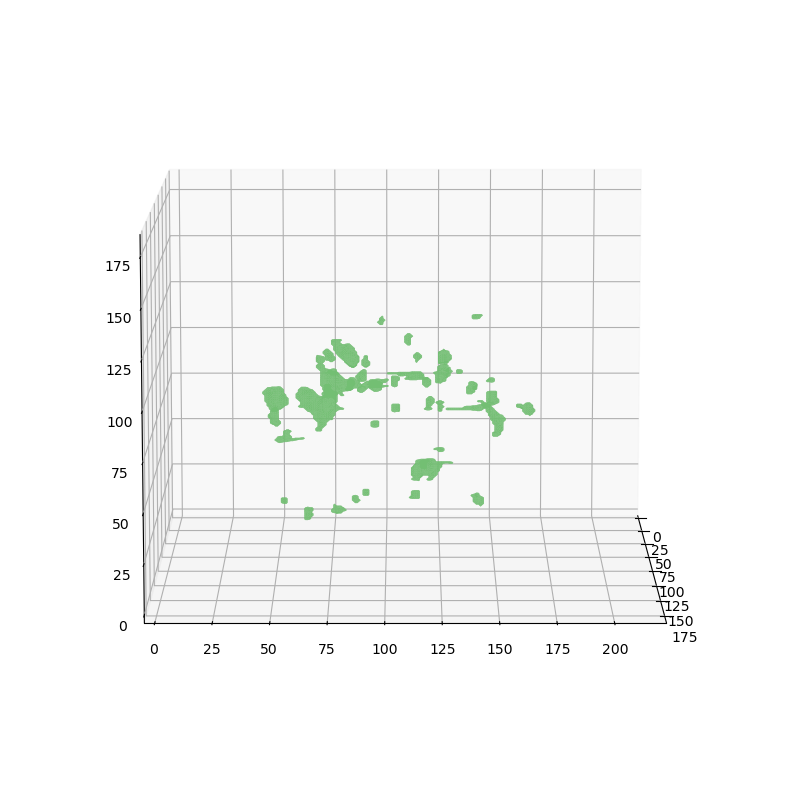

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation


img = nib.load(os.path.join(TRAINING_PATH, "P48", "T1", "P48_T1_MASK.nii.gz"))
binary_mask = img.get_fdata() 
#binary_mask_resized = resize(binary_mask, (98, 98, 98), preserve_range=True)
binary_mask_resized = (binary_mask > 0).astype(int)

verts,faces,_,_ = marching_cubes(binary_mask_resized, step_size=1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.9)
face_color = [0.45,0.75, 0.45]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
ax.set_xlim(0, binary_mask_resized.shape[0])
ax.set_ylim(0, binary_mask_resized.shape[1])
ax.set_zlim(0, binary_mask_resized.shape[2])
def update(angle):
    ax.view_init(elev=10, azim=angle)

ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
#ani.save('animation.gif', writer='pillow', fps=30)
plt.show()